In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import trajectory_new as trj

import zarr
import dask
from timeit import default_timer as timer


In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

2020-12-19 23:01:06
20201219.0
5784887    110400.0
Name: time, dtype: float64
2020-12-20 23:20:05
20201220.0
6112999    110700.0
6275751    232000.0
Name: time, dtype: float64
model predict 0.01132740592584014


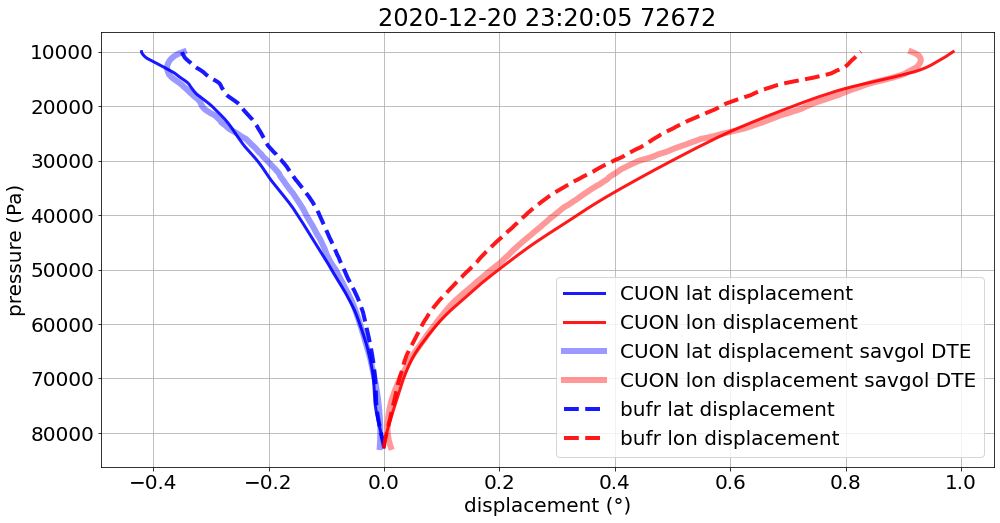

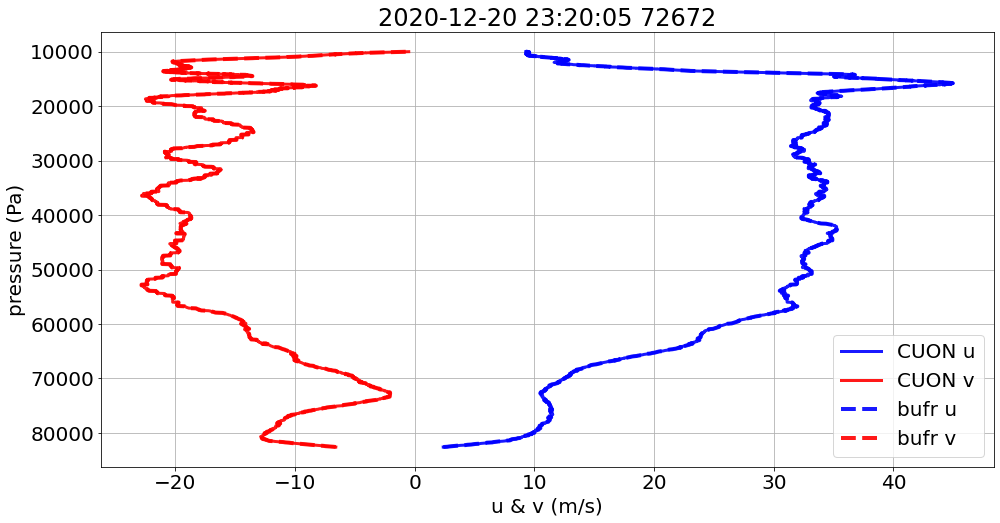

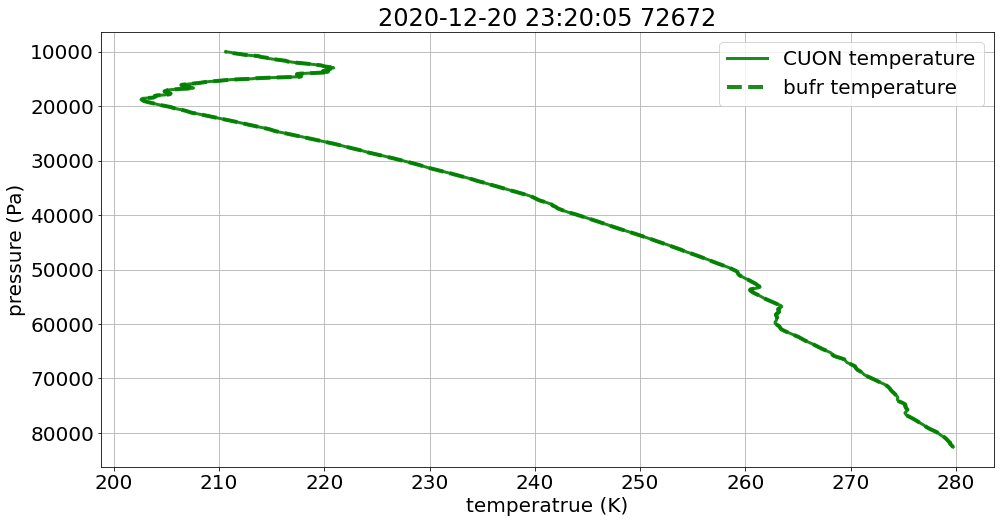

2020-12-21 23:00:55
20201221.0
6380317    110300.0
6518046    230000.0
Name: time, dtype: float64
model predict 0.0025612199679017067


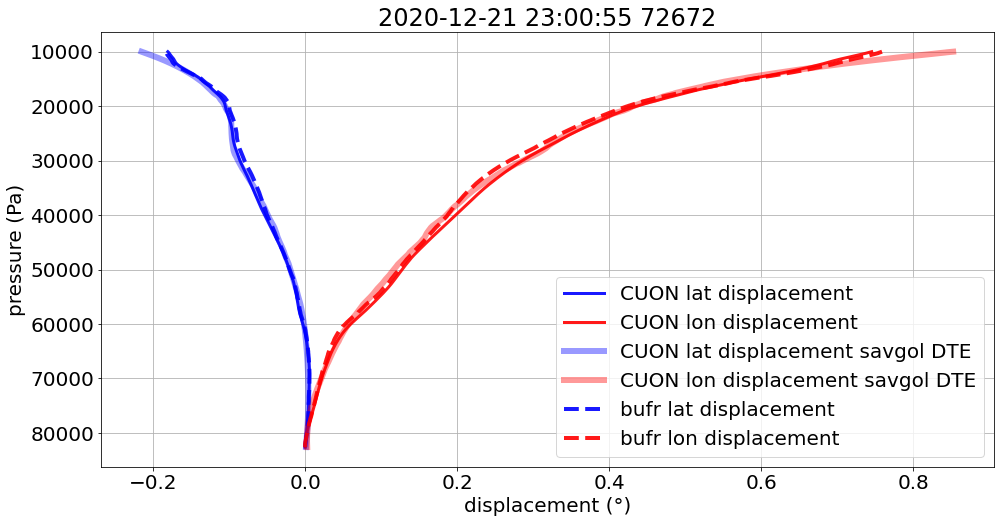

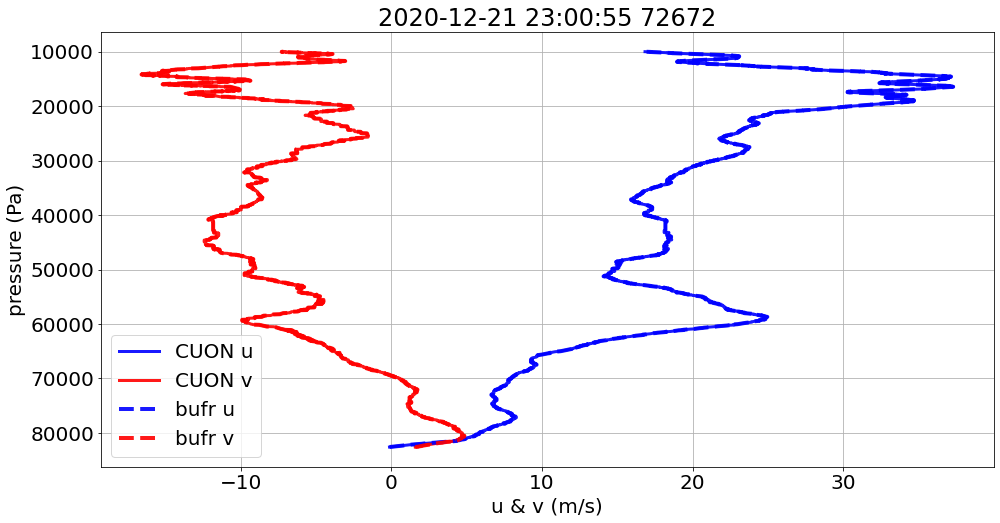

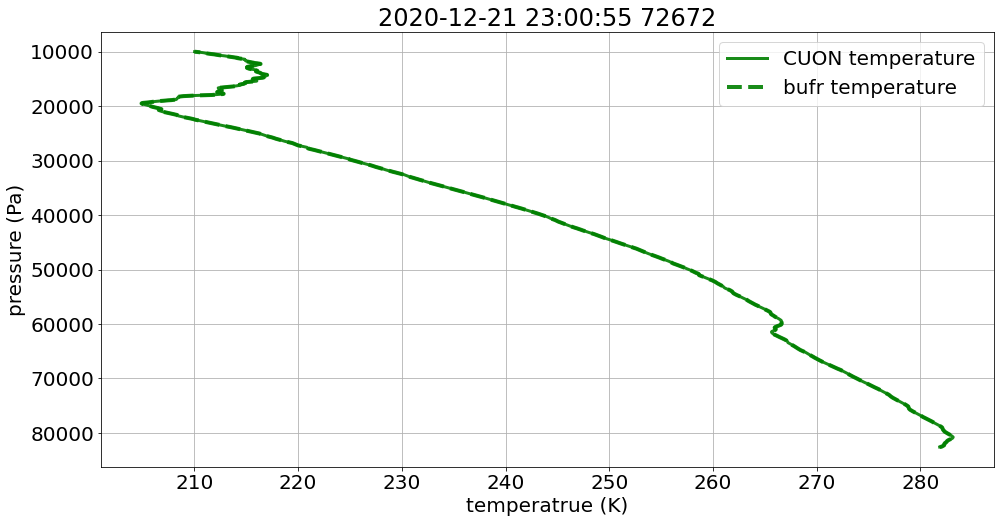

2020-12-22 23:01:37
20201222.0
6679906    110300.0
6819699    230100.0
Name: time, dtype: float64
model predict 0.0025843936018645763


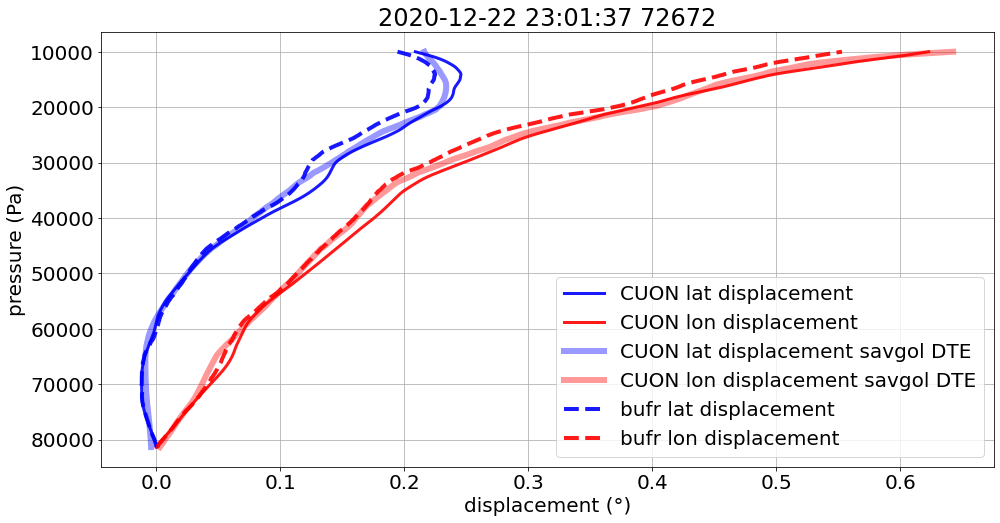

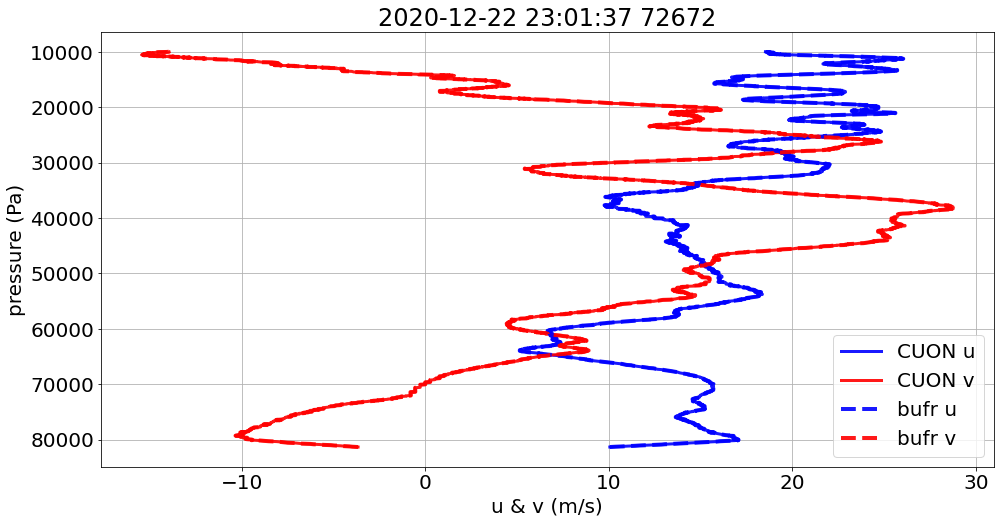

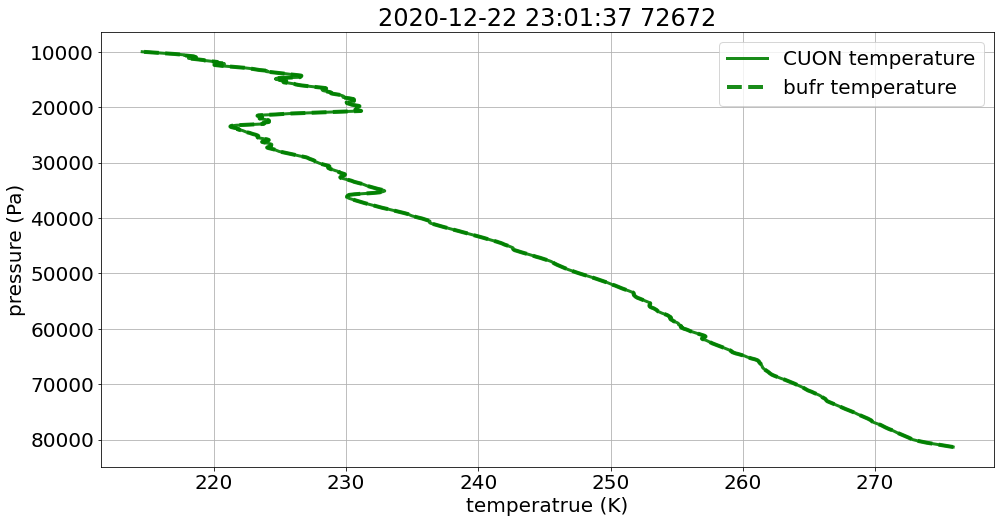

2020-12-23 23:00:55
20201223.0
6985270    110400.0
7118201    230000.0
Name: time, dtype: float64
model predict 0.0030157496221363544


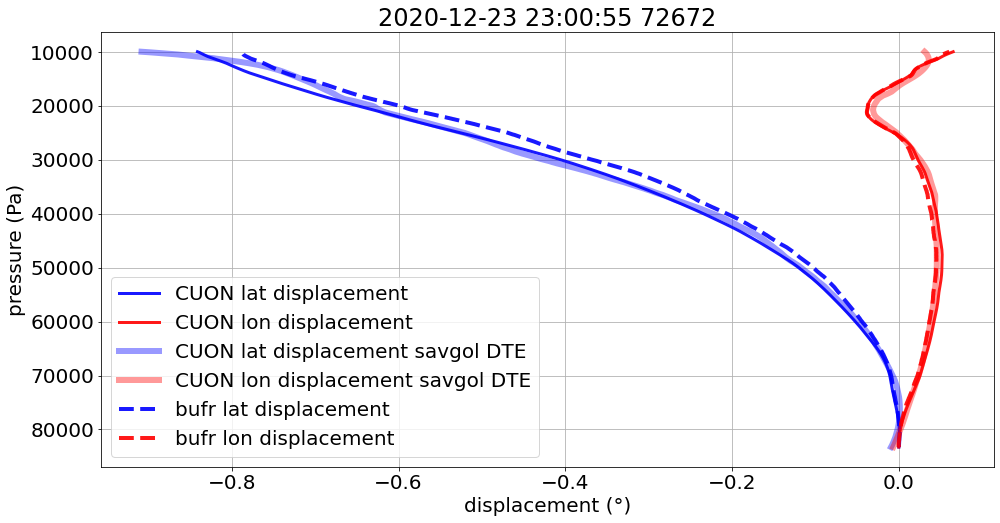

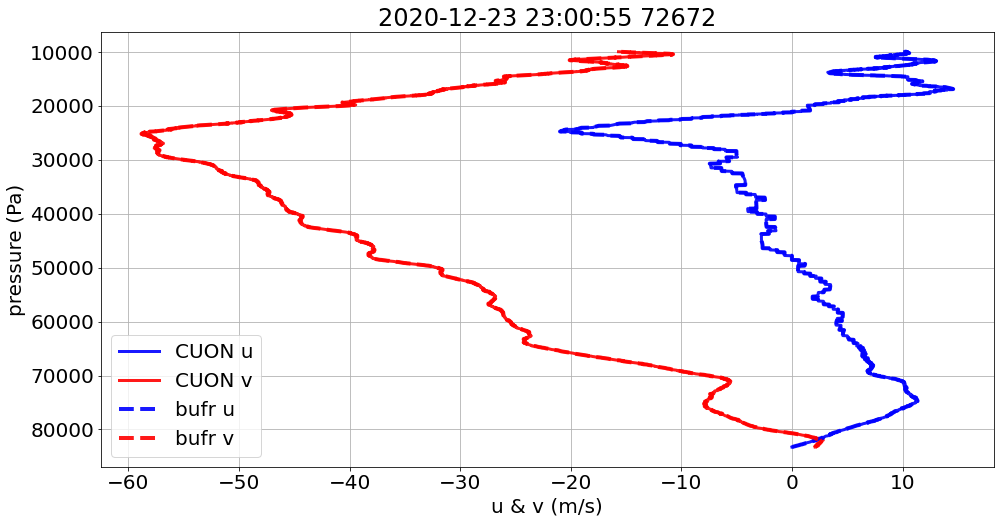

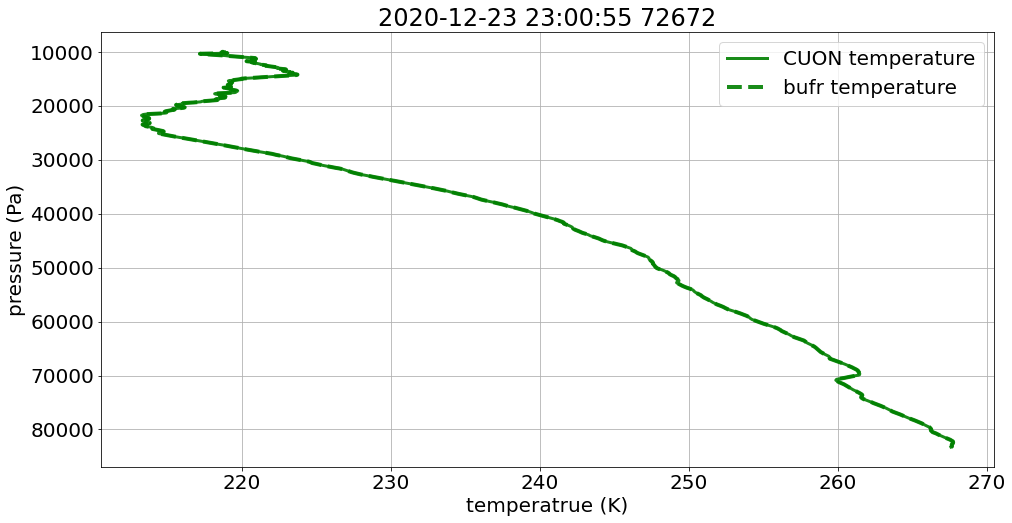

2020-12-24 23:08:40
20201224.0
7297496    110300.0
7466546    230800.0
Name: time, dtype: float64
model predict 0.0033588302321732044


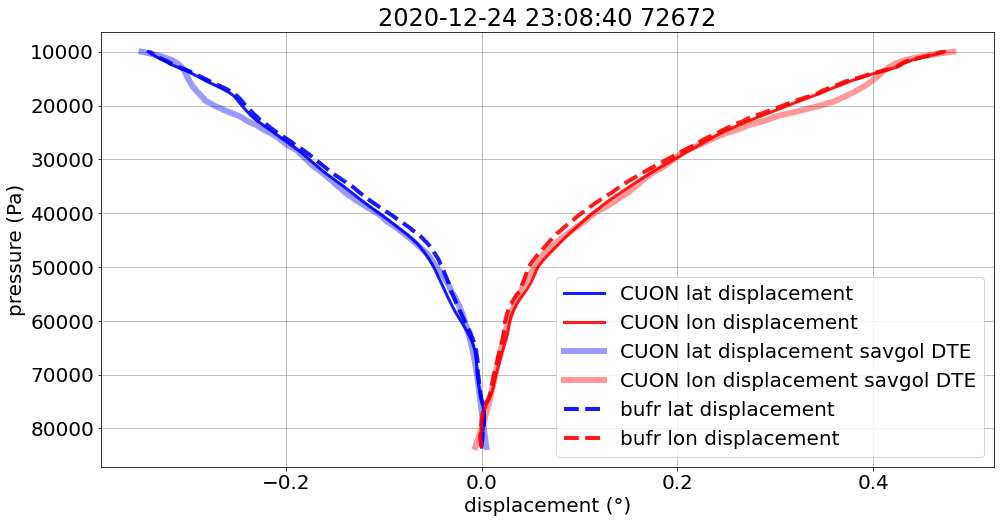

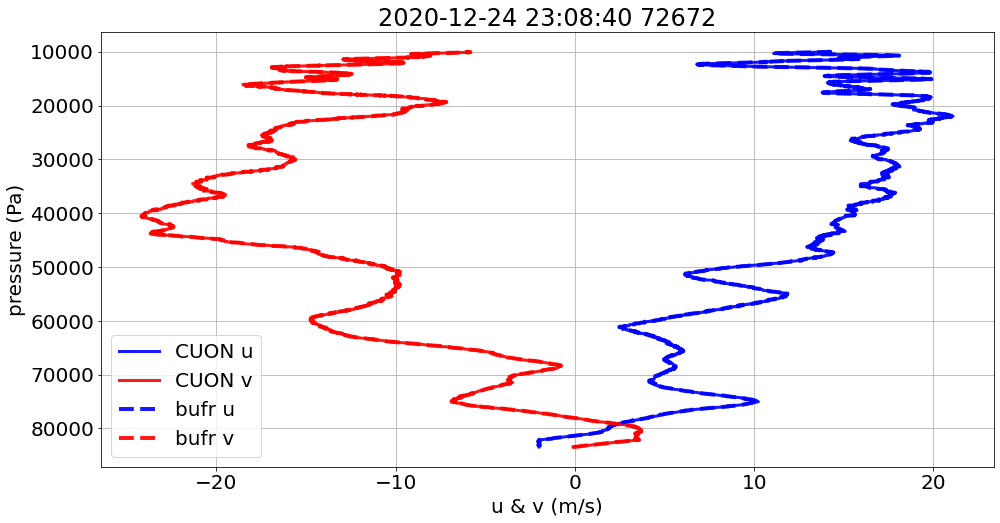

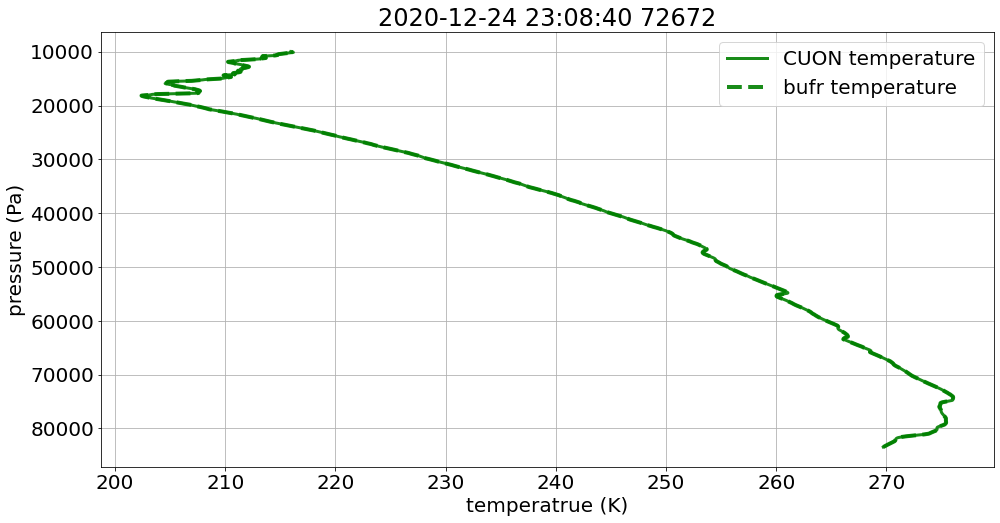

2020-12-25 23:01:17
20201225.0
7692472    230100.0
Name: time, dtype: float64
model predict 0.003273290116339922


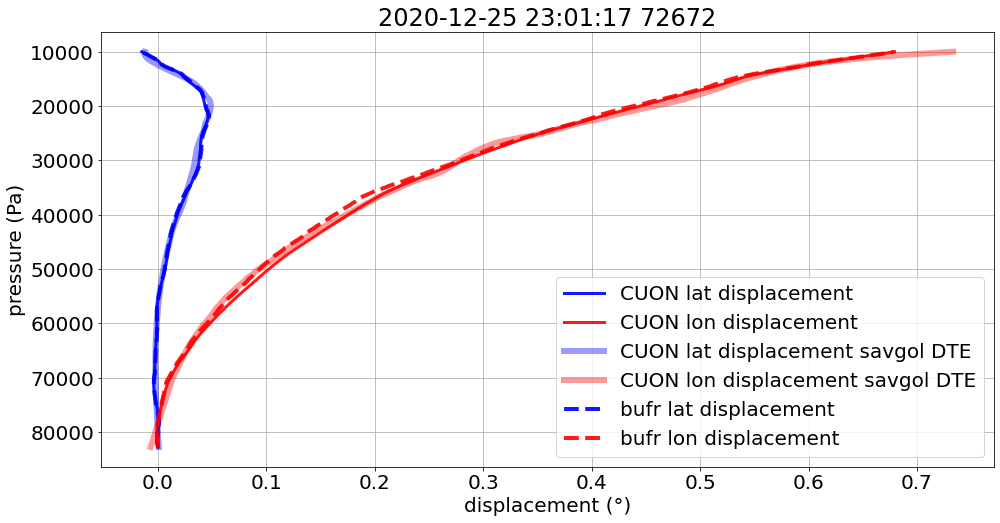

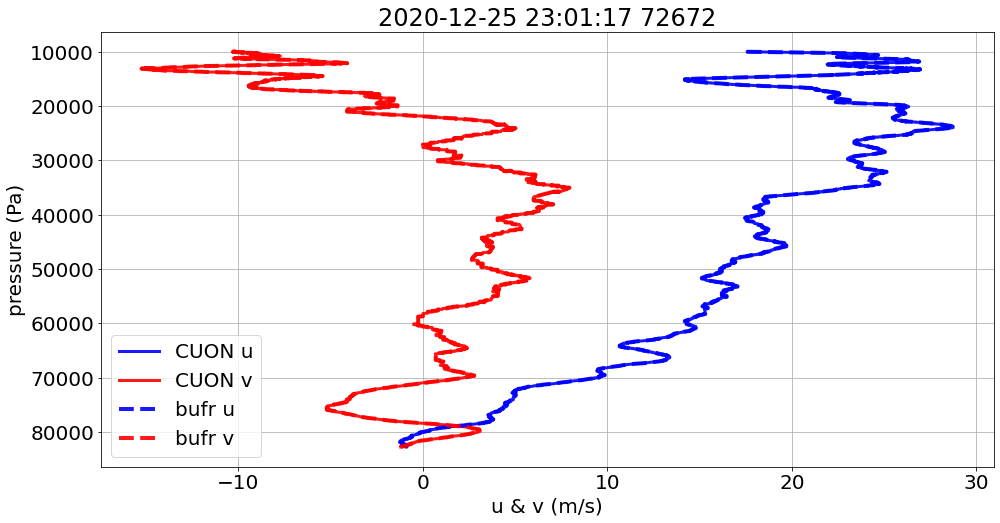

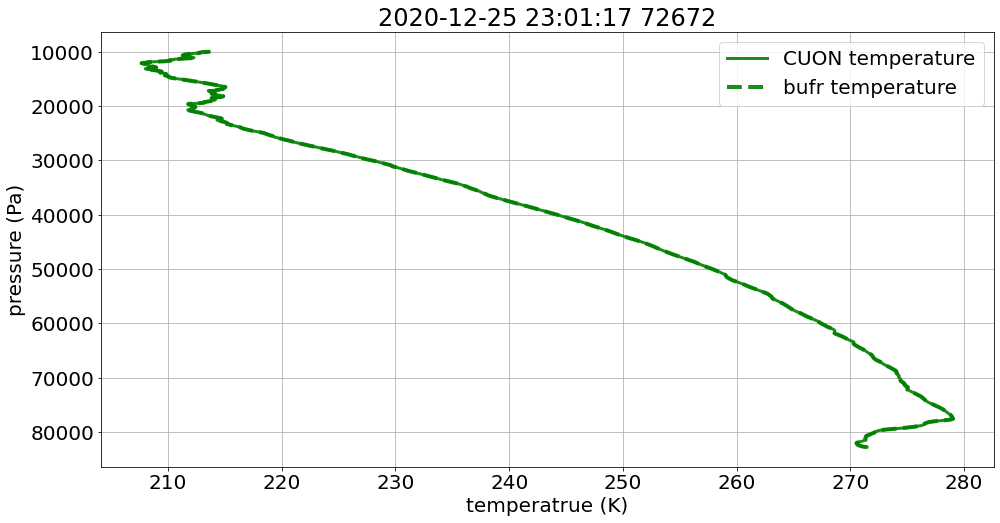

2020-12-26 23:01:41
20201226.0
7839894    110100.0
7965956    230100.0
Name: time, dtype: float64
model predict 0.003502371720969677


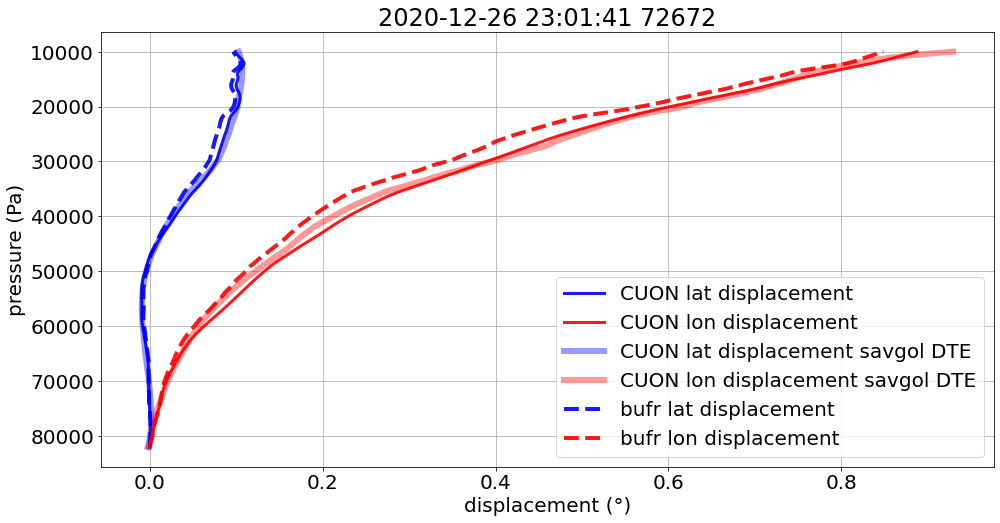

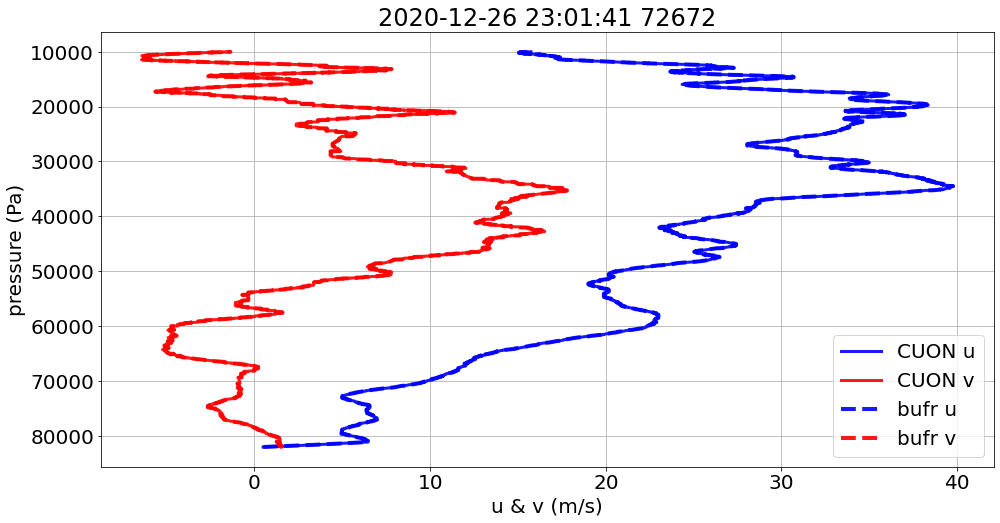

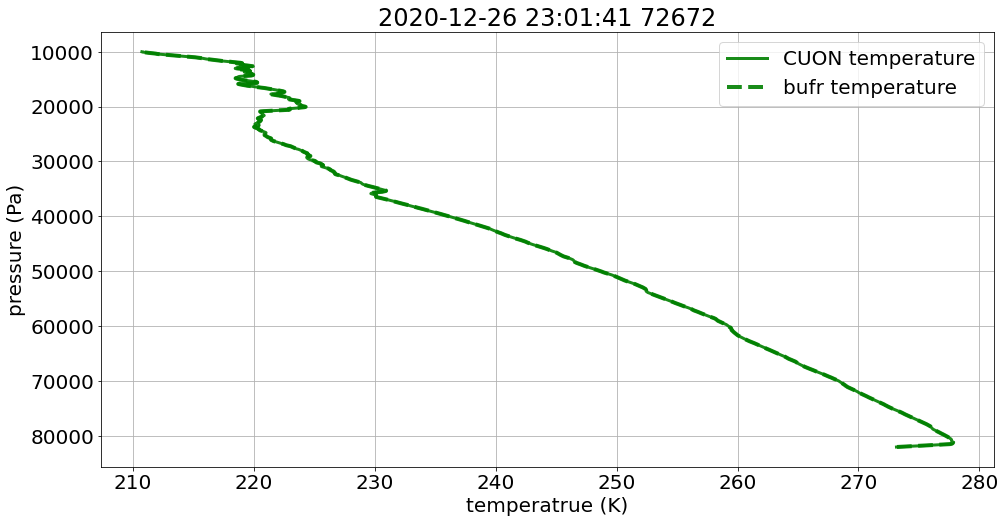

2020-12-27 23:11:36
20201227.0
8157444    110300.0
8318716    231100.0
Name: time, dtype: float64
model predict 0.0036284667439758778


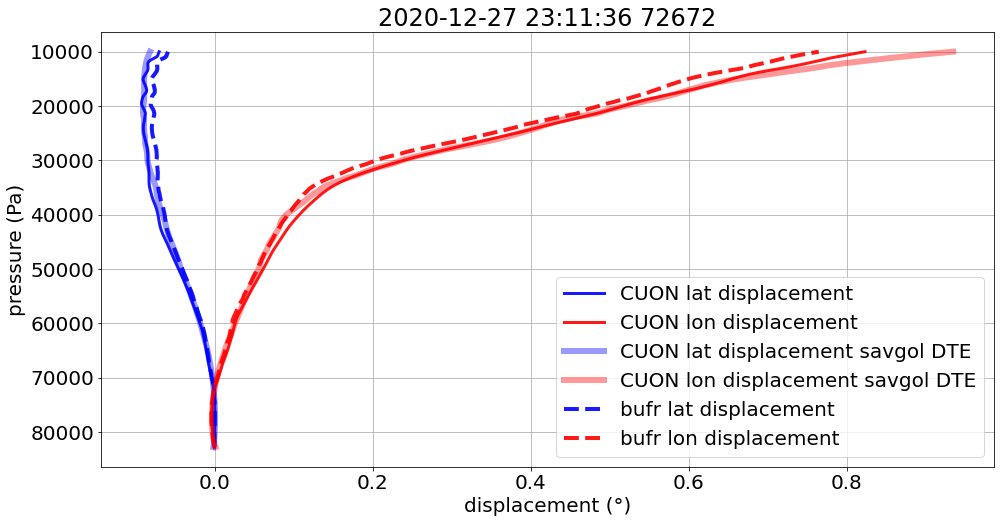

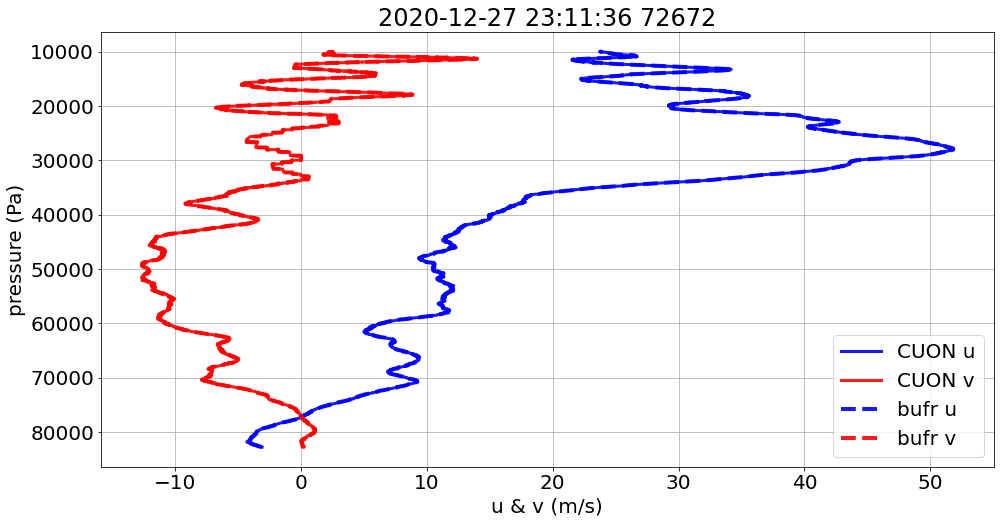

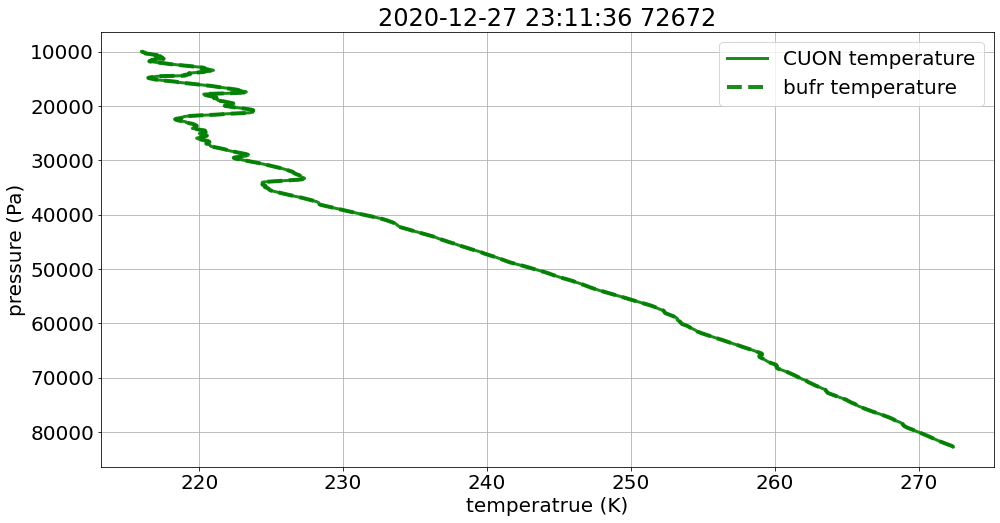

2020-12-28 23:03:09
20201228.0
8420722    110200.0
8551560    230300.0
Name: time, dtype: float64
model predict 0.003786723129451275


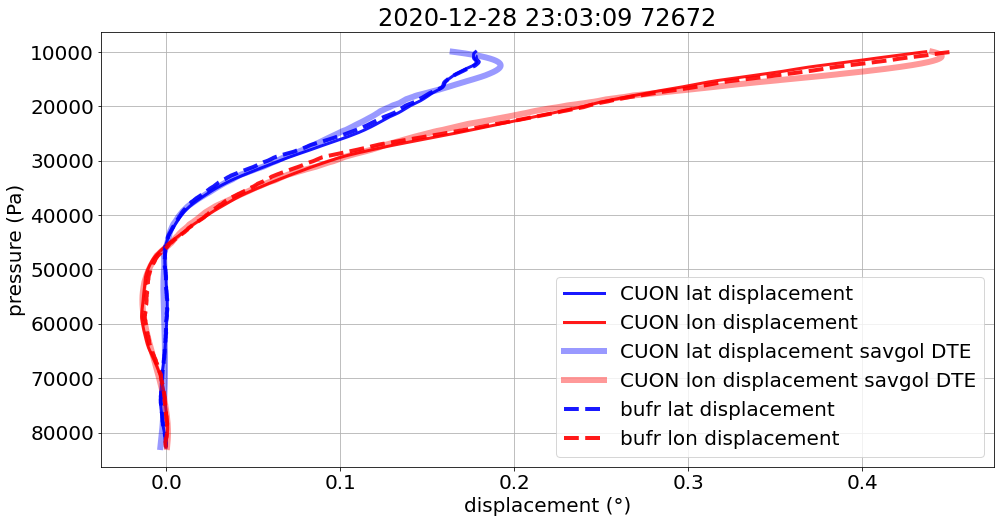

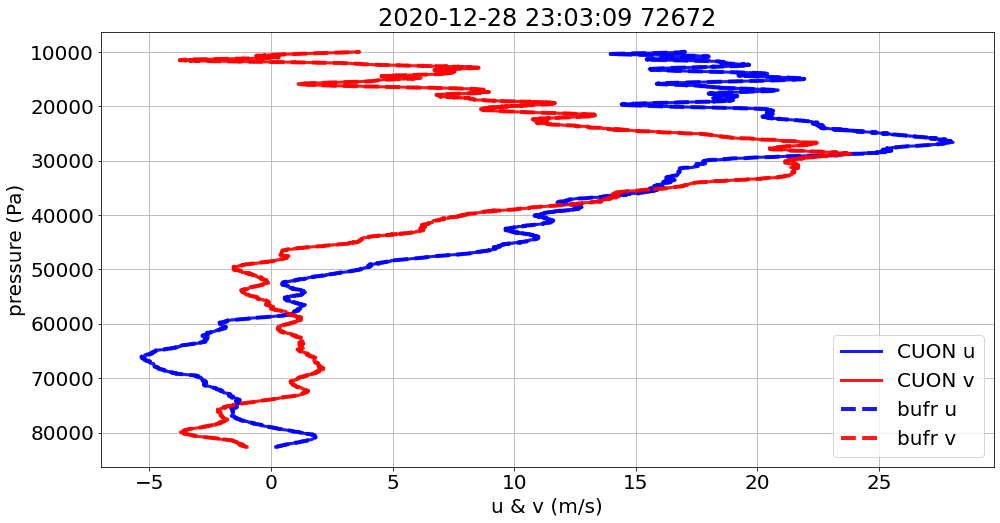

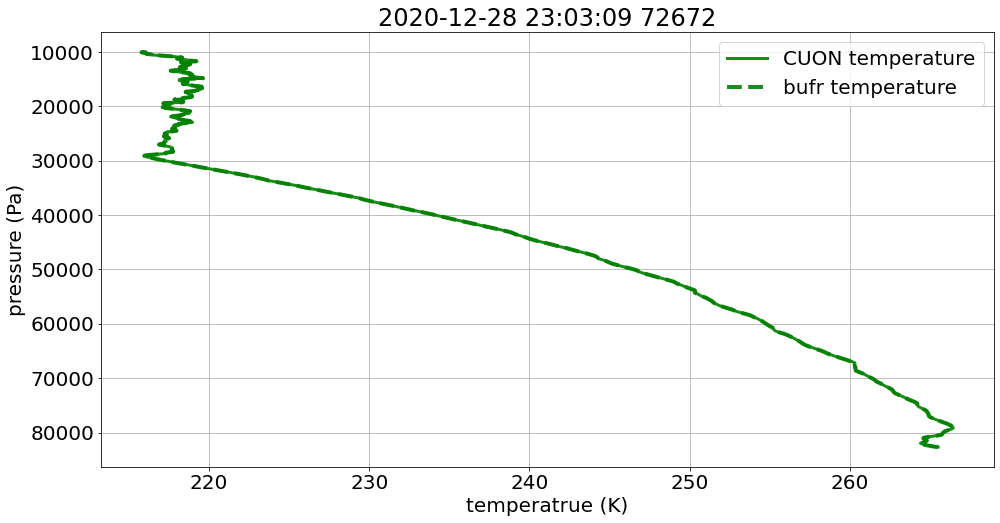

2020-12-29 23:18:06
20201229.0
8752218    110300.0
8955399    231800.0
Name: time, dtype: float64
model predict 0.0029430133290588856


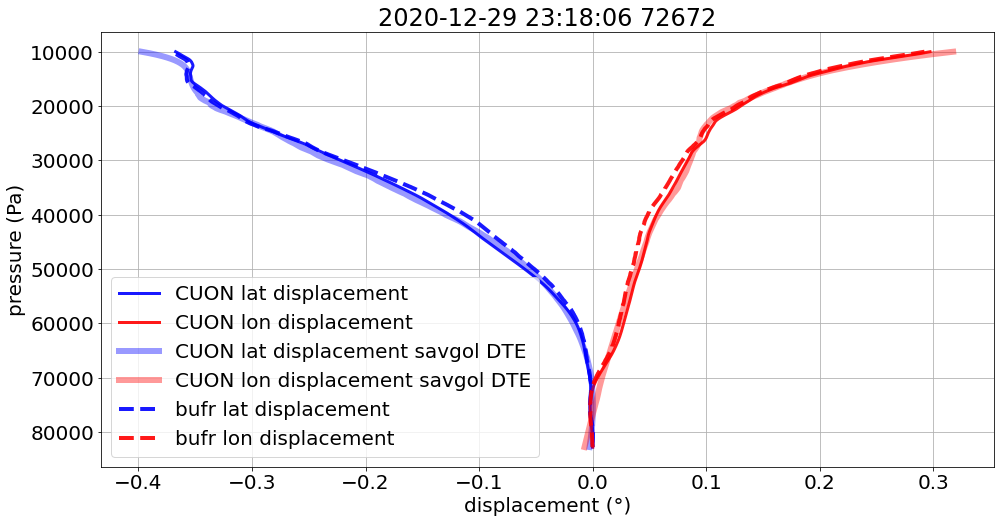

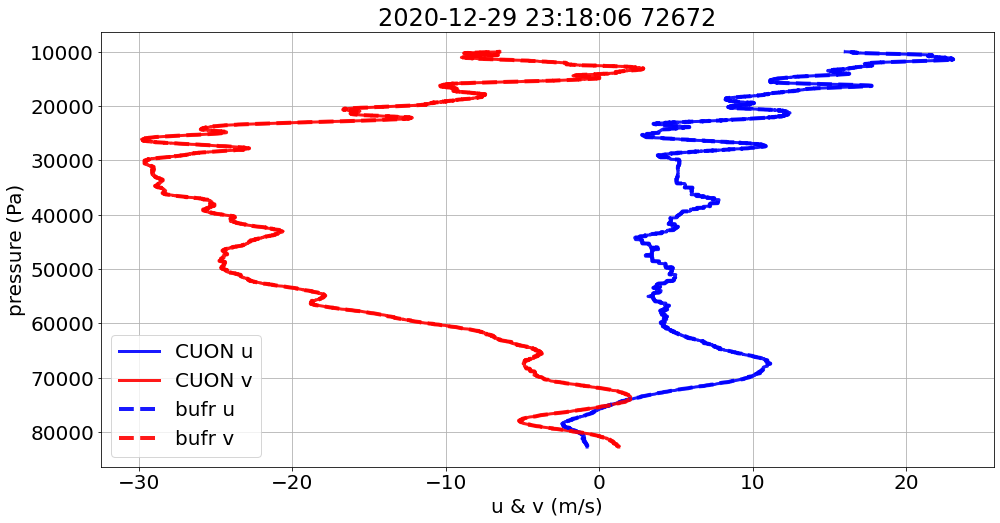

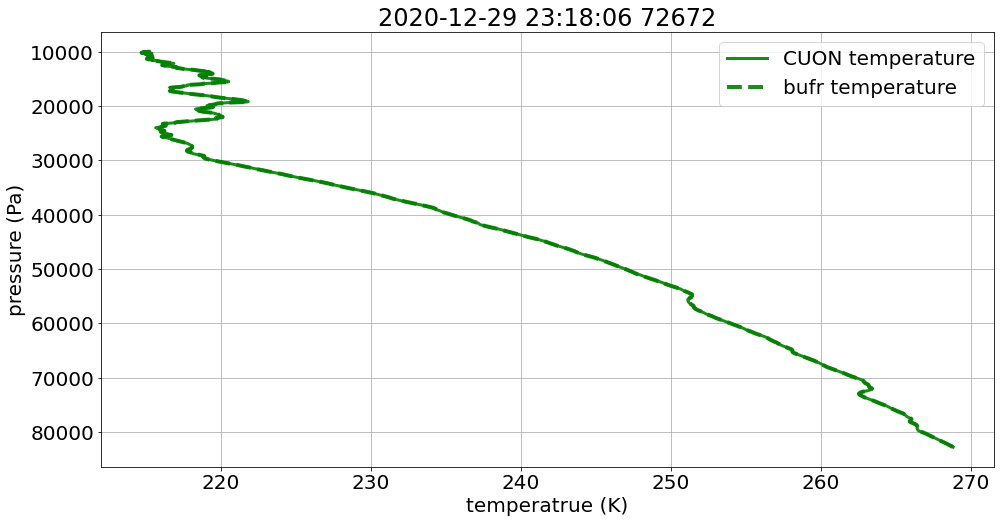

2020-12-30 23:01:19
20201230.0
8998058    110300.0
Name: time, dtype: float64


In [26]:
stat = '72672'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
df = df[df.date_time.dt.month == 12]
df = df[df.date_time >= '2020-12-19 23:01:06']

with open('mldf_compare_full_12_statid.p', "rb") as input_file:
    winter2020 = pickle.load(input_file)
searchlat = df.latitude.iloc[0] 
searchlon = df.longitude.iloc[0]
out = trj.haversine(searchlon, searchlat, winter2020.lon, winter2020.lat)
minid = out[out == min(out)]
found_station = winter2020[winter2020.statid == winter2020.iloc[minid.index[0]].statid]

# df = df[np.isin(df.date_time.dt.month, [3,4,5,6,7,8,9,10,11])]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]


with open('model_dt_no_dec_reduced_prev_new.p', "rb") as input_file:
    model = pickle.load(input_file)
for day in df.date_time.drop_duplicates():
    test = df[df.date_time == day]
    print(day)
    print(float(str(day.year) + "%02d" % (day.month) + "%02d" % (day.day)))
    
    bufrdata = found_station[found_station.date == float(str(day.year) + "%02d" % (day.month) + "%02d" % (day.day))]
    bufr_times = bufrdata.time.drop_duplicates()
    print(bufr_times)
    if not str(bufr_times.iloc[-1])[:2] in ['23', '00']:
        continue
    bufrdata = bufrdata[bufrdata.time == bufr_times.iloc[-1]]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')
#     t = t.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
#     u = u.drop(columns='observed_variable')
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])
#     v = v.drop(columns='observed_variable')

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data[input_data.z_coordinate >= 10000]
    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data = input_data.dropna()
#     display(input_data)
    lat_displacement, lon_displacement, u_shear, v_shear = trj.trajectory(np.array(input_data.latitude)[0], np.array(input_data.longitude)[0], np.array(input_data.u), np.array(input_data.v), np.array(input_data.z_coordinate), np.array(input_data.temperature), z_variant='ucar', factor=1)
#     lat_displacement, lon_displacement, u_shear, v_shear = trj.trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', factor=1)



    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(lat_displacement)
    input_data['calc_lond'] = np.array(lon_displacement)

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()

    t1 = timer()
    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])
    print('model predict', timer() - t1)
    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
#     input_data['ml_latd'] = np.array(ml_latd)
#     input_data['ml_lond'] = np.array(ml_lond)
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 4))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 4))


    input_data = input_data.reset_index()

    fig, ax1 = maplt.subplots(1, figsize=(16, 8))
    ax1.plot(input_data.calc_latd, input_data.z_coordinate, color = 'blue', alpha = 0.9, label='CUON lat displacement')
    ax1.plot(input_data.calc_lond, input_data.z_coordinate, color = 'red', alpha = 0.9, label='CUON lon displacement')
    ax1.plot(input_data.ml_latd, input_data.z_coordinate, color = 'blue', linewidth = 6, alpha = 0.4, label='CUON lat displacement savgol DTE')
    ax1.plot(input_data.ml_lond, input_data.z_coordinate, color = 'red', linewidth = 6, alpha = 0.4, label='CUON lon displacement savgol DTE')
    ax1.plot(bufrdata.latd, bufrdata.pressure, color = 'blue', alpha = 0.9, ls='--', linewidth=4, label='bufr lat displacement')
    ax1.plot(bufrdata.lond, bufrdata.pressure, color = 'red', alpha = 0.9, ls='--', linewidth=4, label='bufr lon displacement')
#     ax1.plot(bufrdata.calc_latd, bufrdata.pressure, color = 'blue', alpha = 0.4, ls='--', linewidth=4, label='bufr calc lat disp')
#     ax1.plot(bufrdata.calc_lond, bufrdata.pressure, color = 'red', alpha = 0.4, ls='--', linewidth=4, label='bufr calc lon disp')
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel('displacement (°)')
    ax1.set_title(str(day)+ ' ' +str(stat))
    ax1.tick_params(axis='y')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.legend()
    ax1.grid()
    maplt.show()
    maplt.close()
    
    
    fig, ax1 = maplt.subplots(1, figsize=(16, 8))
    ax1.plot(input_data.u, input_data.z_coordinate, color = 'blue', alpha = 0.9, label='CUON u')
    ax1.plot(input_data.v, input_data.z_coordinate, color = 'red', alpha = 0.9, label='CUON v')
    ax1.plot(bufrdata.u, bufrdata.pressure, color = 'blue', alpha = 0.9, ls='--', linewidth=4, label='bufr u')
    ax1.plot(bufrdata.v, bufrdata.pressure, color = 'red', alpha = 0.9, ls='--', linewidth=4, label='bufr v')
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel('u & v (m/s)')
    ax1.set_title(str(day)+ ' ' +str(stat))
    ax1.tick_params(axis='y')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.legend()
    ax1.grid()
    maplt.show()
    maplt.close()
    
    
    fig, ax1 = maplt.subplots(1, figsize=(16, 8))
    ax1.plot(input_data.temperature, input_data.z_coordinate, color = 'green', alpha = 0.9, label='CUON temperature')
    ax1.plot(bufrdata.temperature, bufrdata.pressure, color = 'green', alpha = 0.9, ls='--', linewidth=4, label='bufr temperature')
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel('temperatrue (K)')
    ax1.set_title(str(day)+ ' ' +str(stat))
    ax1.tick_params(axis='y')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.legend()
    ax1.grid()
    maplt.show()
    maplt.close()
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(input_data.u, input_data.z_coordinate, color = 'red', alpha = 0.9, label='u')
#     ax1.plot(input_data.v, input_data.z_coordinate, color = 'blue', alpha = 0.9, label='v')
#     ax1.plot(bufrdata.u, bufrdata.pressure, color = 'red', ls='--', linewidth=10, alpha = 0.4, label='u bufr')
#     ax1.plot(bufrdata.v, bufrdata.pressure, color = 'blue', ls='--', linewidth=10, alpha = 0.4, label='v bufr')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('wind (m/s)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()
    
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(input_data.temperature, input_data.z_coordinate, color = 'red', alpha = 0.9, label='temperature')
#     print(input_data.z_coordinate)
#     ax1.plot(bufrdata.temperature, bufrdata.pressure, color = 'red', ls='--', linewidth=10, alpha = 0.4, label='temperature bufr')
#     print(bufrdata.pressure)
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()
    

In [22]:
input_data

,index,latitude,longitude,temperature,z_coordinate,date_time,fg_depar@body,an_depar@body,u,v,z,calc_latd,calc_lond,prev_calc_lond,prev_calc_latd,lat_diff,lon_diff,ml_latd,ml_lond
0,2989,43.06485,-108.476669,275.779999,82740.0,2020-12-19 23:01:06,-1.236315,-1.537086,8.179026,-3.989177,1604.586597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008326,-0.006046
1,2988,43.06485,-108.476669,275.820007,82670.0,2020-12-19 23:01:06,-1.142383,-1.444550,8.628423,-4.208363,1611.419485,-0.000049,0.000140,0.000000,0.000000,-0.000049,0.000140,0.008039,-0.005610
2,2987,43.06485,-108.476669,275.850006,82600.0,2020-12-19 23:01:06,-1.058451,-1.362013,8.987941,-4.383711,1618.259022,-0.000102,0.000289,0.000140,-0.000049,-0.000053,0.000148,0.007753,-0.005176
3,2986,43.06485,-108.476669,275.880005,82540.0,2020-12-19 23:01:06,-0.980531,-1.284710,9.257579,-4.515223,1624.126787,-0.000149,0.000420,0.000289,-0.000102,-0.000047,0.000132,0.007469,-0.004744
4,2985,43.06485,-108.476669,275.910004,82480.0,2020-12-19 23:01:06,-0.901792,-1.206167,9.697494,-4.522016,1629.999525,-0.000197,0.000557,0.000420,-0.000149,-0.000048,0.000137,0.007186,-0.004314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,512,43.06485,-108.476669,216.529999,10040.0,2020-12-19 23:01:06,-1.567943,-1.064114,3.287002,-12.267258,15969.963621,-0.550898,0.565207,0.565156,-0.550759,-0.000139,0.000052,-0.540556,0.551673
2478,511,43.06485,-108.476669,216.449997,10030.0,2020-12-19 23:01:06,-1.650863,-1.144628,3.048216,-12.225726,15976.278313,-0.551037,0.565257,0.565207,-0.550898,-0.000139,0.000050,-0.540429,0.551495
2479,510,43.06485,-108.476669,216.410004,10020.0,2020-12-19 23:01:06,-1.693782,-1.185142,3.048216,-12.225726,15982.597680,-0.551176,0.565305,0.565257,-0.551037,-0.000139,0.000048,-0.540300,0.551313
2480,509,43.06485,-108.476669,216.330002,10010.0,2020-12-19 23:01:06,-1.776701,-1.265655,2.789393,-12.082189,15988.921720,-0.551314,0.565351,0.565305,-0.551176,-0.000138,0.000046,-0.540169,0.551129


In [23]:
bufrdata

,temperature,pressure,u,v,latd,lond,lat,lon,calc_latd,calc_lond,z,u_shear,v_shear,date,time,statid,blockNumber
5784887,266.46,82630.0,1.991716,1.671248,0.00004,0.00012,43.06,-108.48,0.000000,0.000000,1560.342054,0.000000,0.000000,20201219.0,110400.0,672,72
5784888,266.56,82580.0,2.184346,1.587020,0.00010,0.00020,43.06,-108.48,0.000014,0.000024,1565.063974,0.192630,-0.084228,20201219.0,110400.0,672,72
5784889,266.67,82530.0,2.404209,1.621659,0.00018,0.00024,43.06,-108.48,0.000027,0.000051,1569.790615,0.219863,0.034639,20201219.0,110400.0,672,72
5784890,266.78,82480.0,2.598076,1.500000,0.00026,0.00028,43.06,-108.48,0.000041,0.000080,1574.522072,0.193867,-0.121659,20201219.0,110400.0,672,72
5784891,266.88,82420.0,2.673020,1.361971,0.00032,0.00027,43.06,-108.48,0.000055,0.000117,1580.205844,0.074943,-0.138029,20201219.0,110400.0,672,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5787583,217.66,10040.0,22.364264,-11.395162,-0.20074,0.59586,43.06,-108.48,-0.209981,0.618523,15896.889409,0.000000,0.000000,20201219.0,110400.0,672,72
5787584,217.65,10030.0,22.364264,-11.395162,-0.20086,0.59611,43.06,-108.48,-0.210111,0.618874,15903.238225,0.000000,0.000000,20201219.0,110400.0,672,72
5787585,217.65,10020.0,22.186062,-11.304363,-0.20104,0.59657,43.06,-108.48,-0.210241,0.619223,15909.593135,-0.178201,0.090798,20201219.0,110400.0,672,72
5787586,217.65,10010.0,22.186062,-11.304363,-0.20113,0.59683,43.06,-108.48,-0.210371,0.619572,15915.954390,0.000000,0.000000,20201219.0,110400.0,672,72


In [24]:
bufr_times

5784887    110400.0
Name: time, dtype: float64